In [2]:
import tarfile

# Extract the dataset
tgz_file = r"/Users/adirserruya/Projects/MLCourse/HW4 - CNNs/102flowers.tgz"  # Replace with the path to your downloaded file
extract_path = "flowers102"

with tarfile.open(tgz_file, "r:gz") as tar:
    tar.extractall(path=extract_path)

print("Dataset extracted!")


/var/folders/b5/wwf8gkc96dqcxmth13t0vhj80000gn/T/ipykernel_43413/1607971688.py:8: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=extract_path)


Dataset extracted!


In [3]:
# Loading Labels
from scipy.io import loadmat

# Load the labels
annotations = loadmat(fr"/Users/adirserruya/Projects/MLCourse/HW4 - CNNs/imagelabels.mat")
labels = annotations['labels'][0]
print(f"Total labels: {len(labels)}")


Total labels: 8189


# Dataset Preparation

In [7]:
from torchvision import transforms
from sklearn.model_selection import train_test_split
from PIL import Image
import os
import torch
from torch.utils.data import Dataset, DataLoader

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.ToTensor(),          # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Custom Dataset
class Flowers102Dataset(Dataset):
    def __init__(self, img_dir, labels, indices, transform=None):
        self.img_dir = img_dir
        self.labels = labels
        self.indices = indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, f"image_{self.indices[idx]:05d}.jpg")
        image = Image.open(img_path).convert("RGB")
        label = self.labels[self.indices[idx] - 1] - 1  # Convert to 0-based index
        if self.transform:
            image = self.transform(image)
        return image, label

# Split data
image_indices = list(range(1, len(labels) + 1))
train_idx, test_val_idx = train_test_split(image_indices, test_size=0.5, random_state=42)
val_idx, test_idx = train_test_split(test_val_idx, test_size=0.5, random_state=42)

# Create datasets
data_dir = f"{extract_path}/jpg"
train_dataset = Flowers102Dataset(data_dir, labels, train_idx, transform)
val_dataset = Flowers102Dataset(data_dir, labels, val_idx, transform)
test_dataset = Flowers102Dataset(data_dir, labels, test_idx, transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)


In [ ]:
# GPU Names
import torch
from torch import cuda
cuda.get_device_name(0)


# Visualize a sample of the images

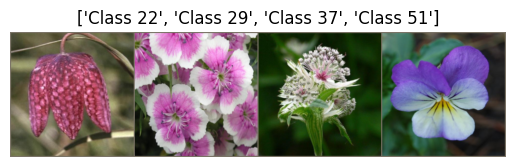

In [11]:

import matplotlib.pyplot as plt
from torchvision import utils as torchvision_utils
import numpy as np

# Function to display a grid of images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))  # Convert to HWC format for displaying
    mean = np.array([0.485, 0.456, 0.406])  # Mean used during normalization
    std = np.array([0.229, 0.224, 0.225])   # Std deviation used during normalization
    inp = std * inp + mean  # Denormalize the image
    inp = np.clip(inp, 0, 1)  # Clip to valid range [0, 1]
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')  # Remove axes for cleaner visualization
    plt.show()

# Get a batch of training data
inputs, classes = next(iter(test_loader))

# Make a grid from batch
out = torchvision_utils.make_grid(inputs)

# Define class names (replace with your actual class names if available)
class_names = [f"Class {i}" for i in range(102)]  # Assuming 102 classes

# Show images
imshow(out, title=[class_names[x] for x in classes])



# Using a pretrained VGG19 for fine-tuning

### Note - Even finetuning took too much time on my Macbook Air :(
    So I rented a mean machine from Vast.ai, 
    Modified Code for distributed trainign will be below 

In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from tqdm import tqdm
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt

# Load pretrained VGG19
vgg19 = models.vgg19(pretrained=True)

# Modify the classifier
num_classes = 102  # Total flower categories
vgg19.classifier[6] = nn.Linear(vgg19.classifier[6].in_features, num_classes)

# Transfer to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg19 = vgg19.to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(vgg19.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training and Validation Loop
def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    train_f1s, val_f1s = [], []
    train_precisions, val_precisions = [], []
    train_recalls, val_recalls = [], []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 20)

        # Training phase
        model.train()
        train_loss = 0.0
        train_preds, train_labels = [], []

        for inputs, labels in tqdm(dataloaders['train'], desc="Training"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

            # Store predictions and true labels
            _, preds = torch.max(outputs, 1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        # Calculate metrics for training
        train_loss = train_loss / len(dataloaders['train'].dataset)
        train_accuracy = accuracy_score(train_labels, train_preds)
        train_f1 = f1_score(train_labels, train_preds, average="weighted")
        train_precision = precision_score(train_labels, train_preds, average="weighted")
        train_recall = recall_score(train_labels, train_preds, average="weighted")

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        train_f1s.append(train_f1)
        train_precisions.append(train_precision)
        train_recalls.append(train_recall)

        print(f"Training Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, F1: {train_f1:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}")

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_preds, val_labels = [], []

        with torch.no_grad():
            for inputs, labels in tqdm(dataloaders['val'], desc="Validation"):
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)

                # Store predictions and true labels
                _, preds = torch.max(outputs, 1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        # Calculate metrics for validation
        val_loss = val_loss / len(dataloaders['val'].dataset)
        val_accuracy = accuracy_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, val_preds, average="weighted")
        val_precision = precision_score(val_labels, val_preds, average="weighted")
        val_recall = recall_score(val_labels, val_preds, average="weighted")

        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        val_f1s.append(val_f1)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)

        print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, F1: {val_f1:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}")

    # Visualization
    epochs = range(1, num_epochs + 1)

    # Loss plot
    plt.figure()
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.title("Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Accuracy plot
    plt.figure()
    plt.plot(epochs, train_accuracies, label="Training Accuracy")
    plt.plot(epochs, val_accuracies, label="Validation Accuracy")
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    # F1 Score plot
    plt.figure()
    plt.plot(epochs, train_f1s, label="Training F1")
    plt.plot(epochs, val_f1s, label="Validation F1")
    plt.title("F1 Score over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("F1 Score")
    plt.legend()
    plt.show()

# Example usage
dataloaders = {'train': train_loader, 'val': val_loader}  # Ensure these are defined
train_model(vgg19, dataloaders, criterion, optimizer, num_epochs=10)


# Multi GPU Distributed Training